# The MNIST dataset

In [1]:
import mxnet as mx
from mxnet import nd,autograd
from mxnet import gluon
import numpy as np

ctx = mx.cpu()

#data shape
batch_size = 64
num_inputs = 784
num_outputs = 10

# data transform
def transform(data,label):
    return data.astype(np.float32)/255,label.astype(np.float32)
    
#dataset
train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True,transform=transform),batch_size,shuffle=True)
test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False,transform=transform),batch_size,shuffle=False)

# Define the model 

In [2]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(num_outputs))

# Parameter Initialization 

In [3]:
net.collect_params().initialize(mx.init.Normal(sigma=1.),ctx=ctx)

# Softmax Cross Entropy Loss 

In [4]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

# Optimizer 

In [5]:
trainer = gluon.Trainer(net.collect_params(),'sgd',{'learning_rate': 0.1})

# Evaluation Metric 

In [6]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

#evaluate_accuracy(test_data, net)

# Execute training loop

In [12]:
epochs = 4
moving_loss = 0.
smoothing_constant = .01
niter = 0

for e in range(epochs):
    for  i, (data ,label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output,label)
        loss.backward()
        trainer.step(batch_size)
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * nd.mean(loss).asscalar()
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)
        
    test_accuracy = evaluate_accuracy(test_data,net)
    train_accuracy = evaluate_accuracy(train_data,net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, est_loss, train_accuracy, test_accuracy))    

Epoch 0. Loss: 0.827579515405, Train_acc 0.835516666667, Test_acc 0.8389
Epoch 1. Loss: 0.676172280202, Train_acc 0.85505, Test_acc 0.8544
Epoch 2. Loss: 0.617506745461, Train_acc 0.864966666667, Test_acc 0.8647
Epoch 3. Loss: 0.55284059913, Train_acc 0.8721, Test_acc 0.8703


(10, 28, 28, 1)
(28, 10, 28, 1)
(28, 280, 1)
(28, 280, 3)


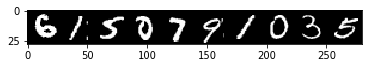

model predictions are: 
[ 6.  1.  5.  0.  7.  9.  1.  0.  3.  5.]
<NDArray 10 @cpu(0)>


In [24]:
import matplotlib.pyplot as plt

#prediction model
def model_predict(net,data):
    output = net(data)
    return nd.argmax(output, axis = 1)

#taking sample data
sample_data  = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False,transform=transform),
                                        10,shuffle=True)

#execute prediction
for i,(data,label) in enumerate(sample_data):
    data = data.as_in_context(ctx)
    print(data.shape)
    im = nd.transpose(data,(1,0,2,3))
    print(im.shape)
    im = nd.reshape(im,(28,10*28,1))
    print(im.shape)
    imtiles = nd.tile(im, (1,1,3))
    print(imtiles.shape)
    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break

